*Technical University of Munich<br>
Professorship of Environmental Sensing and Modeling<br><br>*
**Author:**  Daniel Kühbacher<br>
**Date:**  30.08.2024

--- 

# Optimize volume-capacity thresholds

<!--Notebook description and usage information-->
As road link capacities in traffic models are often adjusted during calibration, vc-thresholds cannot be universally applied and must be carefully reviewed for each specific application. Furthermore, in urban areas, traffic flow is more often limited by the capacity of intersections than by the road links between them. Intersections, where traffic merges and is controlled, tend to create bottlenecks, making them the main factor in determining the traffic condition. Finally, errors can occur when exporting the results of traffic models. For instance, the capacity may refer to both directions combined, but the export shows two separate links, each of which was incorrectly assigned the total capacity. Therefore, it is inevitable to validate and optimize the vc-thresholds applied.</br>

The following script is used to manually optimize the vcr thresholds to reach a traget distribution of vehicle kilometers travelled (VKT) across different traffic conditions. A reference distribution for urban roads in Germany is available in Schmaus et. al (2023). The steps required to conduct the optimization are: 
1. Define variable `optimize_road_type` to subselect one road type for optimization.
2. Explicitely define the `vcr_thresholds` and initialize a hbefa object with these thresholds.
3. Calculate VKT and traffic condition on the given road type using the defined vcr thresholds.
4. Iteratively optimize vcr thresholds until the targeted distribution is achieved (see plot below): Change and run notebook settings, run calculation and run plotting
5. Continue step 1 to 4 for other road types.
6. Add optimized vcr thresholds as default to the hbefa class. 

### References
Schmaus, M., Bawidamann, J., Friedrich, M., Haberl, M., Trenkwalder, L., Fellendorf, M., Uhlig, J., Lohse, R., and Pestel, E.: Flüssiger
Verkehr für Klimaschutz und Luftreinhaltung, Final report 14/2023, Umweltbundesamt (UBA), 2023.70

In [1]:
# import libraries

import sys
import warnings
import os
os.environ['USE_PYGEOS'] = '0'

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime


sys.path.append('../utils')
import data_paths
from traffic_counts import TrafficCounts
from hbefa_hot_emissions import HbefaHotEmissions
from calculate_vkt import calculate_VKT

warnings.filterwarnings("ignore")

# Reload local modules on changes
%reload_ext autoreload
%autoreload 2

# Notebook Settings

In [2]:
# Define start and end time for emission calculation. Ideally this should cover a whole year.
start_date = datetime(2019, 1, 1)
end_date = datetime(2019, 12, 31)

# define filename of the visum file
visum_filename = "visum_links.GPKG"

# if True, the script will only process the area within the ROI defined by roi_polygon
clip_to_area = False # use largest possible area to optimize the vcr thresholds
roi_polygon = data_paths.MUNICH_BOARDERS_FILE # defines ROI for clipping

## Import data

In [3]:
# import visum model, clip it to the ROI, and initialize cycles object

# import visum model
visum = gpd.read_file(data_paths.VISUM_FOLDER_PATH + visum_filename)

if clip_to_area:
    roi = gpd.read_file(roi_polygon).to_crs(visum.crs)
    visum = gpd.clip(visum, roi)
    visum = visum.explode(ignore_index=True) # convert multipolygons to polygons

#visum = visum_links
visum = visum.reset_index(drop = True).reset_index() # reset index for calculation
visum['road_lenght'] = visum['geometry'].length # add road length to visum dict

# initialize traffic cycles
cycles = TrafficCounts(init_timeprofile=False)

# Adapt optimization thresholds

In [4]:
# define which road type to optimize for
optimize_road_type = 'Motorway-Nat'

# define hbefa service thresholds
vcr_thresholds = {'Motorway-Nat': [0.5, 0.71, 0.98, 1.1],
                  'Motorway-City': [0.55, 0.71, 0.98, 1.1], # not used
                  'TrunkRoad/Primary-National': [0.33, 0.5, 0.7, 0.8],
                  'TrunkRoad/Primary-City': [0.67, 0.82, 0.92, 1.02],
                  'Distributor/Secondary': [0.37, 0.5, 0.63, 0.8],
                  'Local/Collector': [0.55, 0.75, 0.9, 1], # not used
                  'Access-residential': [0.14, 0.25, 0.39, 0.52]}

# initialize HBEFA emission factors using the service thresholds
hbefa = HbefaHotEmissions()

# apply service thresholds as defined in the notebook setting
hbefa.vcr_thresholds = vcr_thresholds

Loaded emission factors from /Users/daniel_tum/Documents/code/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_ts_hbefa.txt
Loaded emission factors from /Users/daniel_tum/Documents/code/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_aggregated_hbefa.txt


# Calculate VKT for each vehicle class and traffic condition

In [5]:
#reduce to target road type and caclulate VKT for each day in the timeframe of interest 

# reduce the visum model to the road type of interest
visum_mw = visum[visum['road_type'] == optimize_road_type]#.sample(3000)

# generate dates index
dates = [d.strftime("%Y-%m-%d") for d in pd.date_range(start=start_date,
                                                       end=end_date, freq='1d')]
final_result = {'Freeflow': np.array(5, float),
                'Heavy': np.array(5, float),
                'Satur.': np.array(5, float),
                'St+Go': np.array(5, float),
                'St+Go2': np.array(5, float)}
for date in dates:
    cl, vehicle_index = calculate_VKT(date = date,
                                      visum_dict = visum_mw.to_dict('records'),
                                      cycles_obj = cycles,
                                      hbefa_obj = hbefa)

    for key, value in cl.items():
        final_result[key] = final_result[key] + value

# convert results to dataframe
result_df = pd.DataFrame(final_result, index = vehicle_index)

# Plot VKT share across in all traffic conditions

Only the traffic condition and for PC is used in the plot below

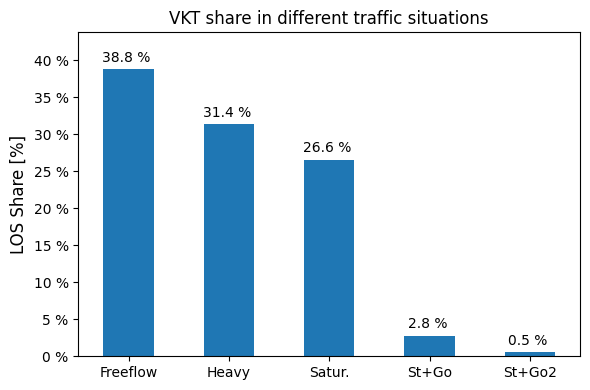

In [6]:
# calculate the share for each traffic condition and plot the results

# calculate the share of vkt for each level of service
total_vkt = result_df.loc['PC'].sum().sum()
vkt_share = (result_df.loc['PC'] / total_vkt)*100

fig, ax = plt.subplots(figsize =(6,4), tight_layout =True)

vkt_share.plot(ax = ax, kind='bar')

plt.title('VKT share in different traffic situations', fontsize = 12)

y_labels = ax.get_yticks()
y_labels = [f'{label:.0f} %' for label in y_labels]
ax.set_xticklabels(labels = ax.get_xticklabels(), rotation=0, fontsize = 10)
ax.set_yticklabels(labels = y_labels, fontsize= 10)
ax.set_ylabel('LOS Share [%]', fontsize = 12)

for i in range(len(vkt_share)):
        plt.text(i, vkt_share[i]+1, f'{vkt_share[i]:.1f} % ', ha = 'center')

plt.ylim(0, vkt_share.max()+5)
plt.show()